In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Adam
import torch.nn.functional as F

import csv
from skimage import io

from PIL import Image
import pandas as pd

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable



import matplotlib.pyplot as plt
import time
import os
import copy

NUM_CLASSES = 10
verbose = False
USE_CUDA = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=128,  out_channels=256, kernel_size=9):
           
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        if verbose: print( "Conv input size{}".format(x.size()))
        output = F.relu(self.conv(x))
        if verbose: print("Conv output feature matrix {}".format(output.shape))
        return output

In [3]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):

        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                          for _ in range(num_capsules)])
    
    def forward(self, x, dimension = 32*6*6):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        if verbose: print( "PrimaryCaps {}".format(u.size()))
        u = u.view(x.size(0), dimension, -1)
        if verbose: print("PrimaryCaps size U {}".format(u.size()))
        output = self.squash(u)
        if verbose: print("Primary Caps output {}".format(output.size()))
        return output
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        if verbose: print(output_tensor.size())
        return output_tensor

In [4]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=NUM_CLASSES, num_routes=32 * 6 * 6 , in_channels=8,  out_channels=16):
        
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        if verbose: print( "DigitCaps x {}, W {}".format(x.size(),self.W.size()))
        W = torch.cat([self.W] * batch_size, dim=0)
        if verbose: print("DigitCaps W {}".format(W.size()))
        u_hat = torch.matmul(W, x)
        if verbose: print("DigitCaps u_hat {}".format(u_hat.size()))
        
        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.to(device)#cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [5]:

def caps_loss(data, x, target, reconstructions):
    return margin_loss(x, target) + reconstruction_loss(data, reconstructions)

def margin_loss( x, labels, size_average=True):
    batch_size = x.size(0)

    v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

    left = F.relu(0.9 - v_c).view(batch_size, -1)
    right = F.relu(v_c - 0.1).view(batch_size, -1)

    if verbose : print("Dimensions of labels {}, left {} right {}".format(labels.shape,left.shape,right.shape))
    loss = labels * left + 0.5 * (1.0 - labels) * right
    loss = loss.sum(dim=1).mean()

    return loss

def reconstruction_loss( data, reconstructions):
    mseloss = nn.MSELoss()
    loss = mseloss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
    if verbose : print("loss {}".format(loss)) 
    return loss * 0.0005

In [6]:
dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),        
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_size = 100

image_datasets = {'train': datasets.CIFAR10('../data', train=True, download=True, transform=dataset_transform),'val': datasets.CIFAR10('../data', train=False, download=True, transform=dataset_transform)}
print("Initializing Datasets and Dataloaders...")

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True) , 'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True) }
print("Initializing Datasets and Dataloaders...")

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}





Files already downloaded and verified
Files already downloaded and verified
Initializing Datasets and Dataloaders...
Initializing Datasets and Dataloaders...


In [24]:
def margin_loss( x, labels, size_average=True):
    batch_size = x.size(0)

    v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

    left = F.relu(0.9 - v_c).view(batch_size, -1)
    right = F.relu(v_c - 0.1).view(batch_size, -1)

    loss = labels * left + 0.5 * (1.0 - labels) * right
    loss = loss.sum(dim=1).mean()

    return loss

def model_loss( x, target):
    return margin_loss(x, target)

def decoder(x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.eye(NUM_CLASSES))
        if USE_CUDA:
            masked = masked.to(device)#cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        return masked

In [26]:
from torchsummary import summary
model = torchvision.models.resnet18(pretrained=True)
modules = list(model.children())[:-4]
model=nn.Sequential(*modules)
for param in model.parameters():
    param.requires_grad = False
    
model.layer3 = nn.Sequential(ConvLayer(), PrimaryCaps(), DigitCaps())
loss_train = []        
accuracy_train = []

model = model.to(device)
optimizer = optim.Adam(model.layer3.parameters(),lr = 0.001)
start = time.time()
n_epochs = 3

for epoch in range(n_epochs):
        model.train() 
        
        train_loss = 0
        train_accuracy = 0
        print('Epoch {}/{}'.format(epoch,3-1))
        print('-'*10)
        for batch_id, (inputs, labels) in enumerate(dataloaders['train']):
            #inputs, labels = next(iter(dataloaders['train']))

            labels =torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = model_loss(outputs, labels)
            masked = decoder(outputs, inputs)
        
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            train_accuracy += (sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
            
            if batch_id % 100 == 0:
                print("train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                       np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
                print("masked {}".format(np.argmax(masked.data.cpu().numpy(), 1)))
                print("labels {}".format(np.argmax(labels.data.cpu().numpy(), 1)))
#                batch_accuracy.append(sum(np.argmax(preds.data.cpu().numpy(), 1) == 
#                                       np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
        
        loss_train.append(train_loss/len(dataloaders['train']))
        accuracy_train.append(train_accuracy/len(dataloaders['train']))
end = time.time()
print("Training time execution {}".format(end-start))
print("Loss value for training phase: {}".format(train_loss / len(dataloaders['train'])))
print("Accuracy value for training phase: {}".format(train_accuracy / len(dataloaders['train'])))

Epoch 0/2
----------
train accuracy: 0.0
masked [0 0 1 7 6 6 7 8 3 0]
labels [2 4 0 5 7 4 9 5 5 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train accuracy: 0.1
masked [0 2 0 8 6 6 1 2 4 0]
labels [4 6 7 7 1 3 1 3 3 4]
train accuracy: 0.1
masked [2 9 2 7 6 4 0 0 3 0]
labels [1 1 0 1 3 4 8 8 4 8]
train accuracy: 0.1
masked [6 1 2 0 0 2 3 2 9 0]
labels [6 6 6 3 8 6 9 3 4 5]
train accuracy: 0.3
masked [9 0 7 9 2 0 2 0 9 2]
labels [8 0 7 5 8 8 4 0 8 3]
train accuracy: 0.3
masked [2 0 7 2 9 2 0 5 6 0]
labels [2 1 7 3 1 2 7 3 3 8]
train accuracy: 0.3
masked [1 6 2 6 7 8 3 6 0 7]
labels [1 3 6 3 4 1 3 1 0 2]
train accuracy: 0.3
masked [2 5 4 6 7 3 0 1 0 1]
labels [5 5 5 0 3 5 9 8 0 1]
train accuracy: 0.5
masked [6 0 5 7 1 2 7 6 6 1]
labels [7 0 5 7 8 4 9 6 6 6]
train accuracy: 0.4
masked [5 8 1 6 4 1 7 7 0 0]
labels [4 0 6 4 4 5 7 8 0 0]
train accuracy: 0.5
masked [6 0 0 7 0 8 5 2 1 7]
labels [6 4 4 7 9 8 5 4 1 6]
train accuracy: 0.4
masked [6 6 2 1 0 5 0 7 9 2]
labels [6 3 7 1 2 3 1 7 9 3]
train accuracy: 0.6
masked [8 0 6 1 7 8 9 6 2 2]
labels [1 3 6 1 3 8 9 6 2 7]
train accuracy: 0.3
masked [7 0 9 8 6 7 6 8 4 1]
labels [7 3 9 3

train accuracy: 0.5
masked [6 7 3 9 5 7 3 1 4 6]
labels [2 7 5 9 3 4 3 1 6 6]
train accuracy: 0.7
masked [5 8 5 3 7 0 1 1 4 2]
labels [2 8 5 3 5 7 1 1 4 2]
train accuracy: 0.9
masked [9 1 9 0 8 6 3 6 1 4]
labels [9 1 9 0 8 6 3 6 1 7]
train accuracy: 0.8
masked [5 7 3 0 0 9 6 1 5 6]
labels [5 7 5 0 5 9 6 1 5 6]
train accuracy: 0.6
masked [9 8 1 8 0 2 6 4 1 9]
labels [1 1 1 8 0 0 2 4 1 9]
train accuracy: 0.8
masked [8 5 6 0 6 5 7 7 8 2]
labels [8 5 3 0 2 5 7 7 8 2]
train accuracy: 0.8
masked [9 8 0 0 4 3 0 5 2 3]
labels [9 8 0 8 4 3 0 5 8 3]
train accuracy: 0.6
masked [8 9 6 6 4 1 2 3 8 0]
labels [8 9 6 6 4 0 6 4 1 0]
train accuracy: 0.9
masked [9 1 0 4 7 0 8 8 0 6]
labels [9 1 0 4 2 0 8 8 0 6]
train accuracy: 0.8
masked [0 4 3 7 9 6 7 1 4 5]
labels [0 4 3 2 9 3 7 1 4 5]
train accuracy: 0.6
masked [4 1 0 5 1 0 2 3 0 5]
labels [3 1 0 3 1 0 7 5 0 5]
train accuracy: 0.9
masked [6 8 7 9 6 4 1 2 4 0]
labels [6 8 7 9 6 4 1 2 4 2]
train accuracy: 0.8
masked [3 2 0 9 0 4 5 6 0 0]
labels [5 2 0 9

In [31]:
model.eval()
test_loss = 0
test_accuracy = 0
start = time.time()
for batch_id, (inputs, labels) in enumerate(dataloaders['val']):
    labels =torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)
    inputs, labels = Variable(inputs), Variable(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    masked = decoder(outputs, inputs)
    
    loss = model_loss(outputs, labels)
    test_loss += loss.data[0]
    test_accuracy += (sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
    
    if batch_id % 100 == 0:
            print("test accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(labels.data.cpu().numpy(), 1)) / float(batch_size))
            print("masked {}".format(np.argmax(masked.data.cpu().numpy(), 1)))
            print("labels {}".format(np.argmax(labels.data.cpu().numpy(), 1)))
        
            
end = time.time()   
print("Validation time execution {}".format(end-start))
print("Loss value for test phase: {}".format(test_loss / len(dataloaders['val'])))
print("Accuracy value for test phase: {}".format(test_accuracy / len(dataloaders['val'])))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


test accuracy: 0.8
masked [3 4 8 3 9 0 9 3 2 6]
labels [3 4 8 3 9 8 9 3 3 6]
test accuracy: 0.7
masked [8 5 0 3 6 0 6 7 6 0]
labels [8 5 7 5 3 0 6 7 6 0]
test accuracy: 0.8
masked [4 7 4 1 0 8 6 2 2 5]
labels [2 7 4 1 0 8 6 3 2 5]
test accuracy: 0.9
masked [1 4 3 6 8 3 1 6 5 6]
labels [1 4 3 6 8 4 1 6 5 6]
test accuracy: 0.6
masked [0 6 7 6 0 9 1 3 5 2]
labels [0 4 7 5 0 0 4 3 5 2]
test accuracy: 0.8
masked [5 5 7 0 6 2 4 7 9 7]
labels [5 5 7 1 6 4 4 7 9 7]
test accuracy: 0.7
masked [9 0 3 9 2 7 8 9 5 1]
labels [9 2 8 9 2 7 8 5 5 1]
test accuracy: 0.8
masked [5 6 3 3 6 0 9 0 6 3]
labels [5 6 3 3 6 0 3 0 6 5]
test accuracy: 0.9
masked [6 0 3 7 7 0 5 8 7 3]
labels [6 7 3 7 7 0 5 8 7 3]
test accuracy: 0.8
masked [4 2 3 9 0 5 3 6 6 6]
labels [4 2 4 9 0 5 3 2 6 6]
Validation time execution 62.89648675918579
Loss value for test phase: 0.3588980734348297
Accuracy value for test phase: 0.7514999999999983


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

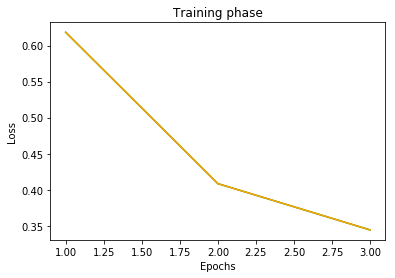

In [36]:
print(model)
import matplotlib.pyplot as plt
n_epochs = 3
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs, loss_train, color='g')
plt.plot(epochs, loss_train, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training phase')
plt.show()

In [ ]:
torch.cuda.empty_cache()